## Курсовой проект по теме "Библиотеки Python для Data Science: продолжение"

# Версия 3.0

**Содержание**

* [Подключение библиотек](#lib)
* [Пути к директориям](#dir)
* [Загрузка и обзор данных](#load_data)
* [Обзор целевой переменной](#target)
* [Обзор признаков](#featur)
* [Обработка признаков](#null)
* [Поиск выбросов](#anom)
* [Кодирование признаков](#encod)
* [Проверка на корреляции](#corr)
* [Обзор признака Credit_Score](#score)
* [Подготовка данных к моделированию, скалирование](#scal)
* [Построение и оценка базовых моделей](#model)
* [Финальная модель](#final_model)

### Подключение библиотек и необходимые функции 
<a class="anchor" id="lib"></a>

In [1]:
import numpy as np
import pandas as pd
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression

import pandas as pd
import numpy as np
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

from hyperopt import hp, tpe
from hyperopt.fmin import fmin

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [3]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        return mis_val_table_ren_columns

In [4]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [5]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [6]:
def hyperopt_xgb_score(params):
    clf = xgb.XGBClassifier(**params)
    # усреднение по 3ем фолдам, для уменьшения влияния стахостичности
    # для ускорения можно использовать train_test_split один раз
    current_score = cross_val_score(clf, X, y, cv=3).mean()
    print(current_score, params)
    return -current_score

In [7]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [8]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

### Пути к директориям и файлам<a class="anchor" id="dir"></a>

In [240]:
# input
DATASET_PATH_TRAIN = 'course_project_train.csv'
DATASET_PATH_TEST = 'course_project_test.csv'

# output
MODEL_FILE_PATH = '../model.pkl'

### Загрузка и обзор данных<a class="anchor" id="load_data"></a>

In [10]:
df_train = pd.read_csv(DATASET_PATH_TRAIN)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [11]:
df_test = pd.read_csv(DATASET_PATH_TEST)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [174]:
df_test.index

RangeIndex(start=0, stop=2500, step=1)

In [12]:
df_train.shape, df_test.shape

((7500, 17), (2500, 16))

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

### Обзор целевой переменной<a class="anchor" id="target"></a>

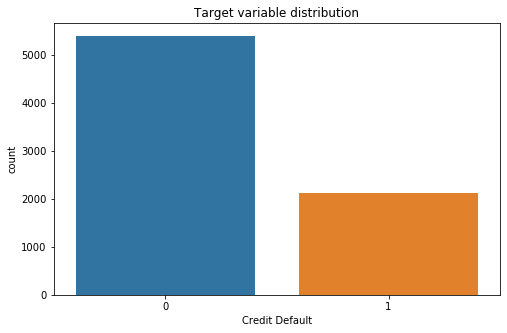

In [15]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df_train['Credit Default'], data=df_train)
plt.title('Target variable distribution')
plt.show()

### Обзор признаков<a class="anchor" id="featur"></a>

In [17]:
missing_values_tr = missing_values_table(df_train)
missing_values_tr

Your selected dataframe has 17 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values
Months since last delinquent,4081,54.4
Annual Income,1557,20.8
Credit Score,1557,20.8
Years in current job,371,4.9
Bankruptcies,14,0.2


In [18]:
missing_values_ts = missing_values_table(df_test)
missing_values_ts

Your selected dataframe has 16 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values
Months since last delinquent,1358,54.3
Annual Income,513,20.5
Credit Score,513,20.5
Years in current job,86,3.4
Bankruptcies,3,0.1


**Убедимся, что пропуски среднего дохода и кредитного рейтинга в одних и тех же строках**

In [30]:
df_train[df_train['Annual Income'].isnull() & df_train['Credit Score'].isnull()].iloc[:, :]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1
10,Home Mortgage,NaN,< 1 year,0.0,7.0,11.5,256322.0,0.0,NaN,0.0,debt consolidation,Short Term,220858.0,187492.0,14592.0,NaN,0
16,Rent,NaN,7 years,0.0,6.0,17.8,899492.0,0.0,NaN,0.0,debt consolidation,Long Term,313038.0,538346.0,18844.0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7482,Home Mortgage,NaN,10+ years,0.0,14.0,30.5,645062.0,0.0,45.0,0.0,debt consolidation,Short Term,188430.0,518662.0,23506.0,NaN,0
7492,Home Mortgage,NaN,10+ years,0.0,10.0,13.3,423984.0,0.0,NaN,0.0,debt consolidation,Short Term,332948.0,161481.0,20966.0,NaN,0
7494,Own Home,NaN,< 1 year,0.0,7.0,8.2,301554.0,0.0,NaN,0.0,debt consolidation,Short Term,290400.0,210938.0,5070.0,NaN,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0


In [ ]:
df_train[df_train['Annual Income'].isnull() & df_train['Credit Score'].isnull()]

In [29]:
df_test[df_test['Annual Income'].isnull() & df_test['Credit Score'].isnull()].iloc[:, :]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
8,Rent,NaN,5 years,0.0,8.0,9.1,370524.0,0.0,NaN,0.0,major purchase,Short Term,131956.0,237747.0,10112.0,NaN
16,Rent,NaN,1 year,0.0,21.0,10.4,613404.0,0.0,NaN,0.0,debt consolidation,Short Term,557480.0,486856.0,26230.0,NaN
20,Home Mortgage,NaN,5 years,0.0,10.0,24.5,4092528.0,0.0,26.0,0.0,debt consolidation,Long Term,344476.0,463011.0,12732.0,NaN
27,Home Mortgage,NaN,6 years,0.0,10.0,6.4,631202.0,0.0,NaN,0.0,debt consolidation,Short Term,444576.0,378328.0,19038.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2469,Rent,NaN,3 years,0.0,8.0,14.8,369974.0,0.0,10.0,0.0,debt consolidation,Short Term,267608.0,238697.0,16371.0,NaN
2475,Rent,NaN,6 years,0.0,13.0,13.5,455378.0,0.0,81.0,0.0,debt consolidation,Short Term,182182.0,149055.0,11688.0,NaN
2479,Home Mortgage,NaN,3 years,0.0,18.0,11.6,606628.0,0.0,23.0,0.0,debt consolidation,Short Term,260458.0,371963.0,18859.0,NaN
2487,Home Mortgage,NaN,10+ years,0.0,24.0,36.6,3341228.0,0.0,NaN,0.0,debt consolidation,Short Term,455950.0,1255235.0,44682.0,NaN


In [21]:
df_train.dtypes.value_counts()

float64    12
object      4
int64       1
dtype: int64

In [22]:
df_train.select_dtypes('object').apply(pd.Series.nunique, axis=0)

Home Ownership           4
Years in current job    11
Purpose                 15
Term                     2
dtype: int64

In [23]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

### Обработка признаков<a class="anchor" id="null"></a>

In [25]:
df_annual = df_train[df_train['Current Loan Amount']!=99999999.0].iloc[:, :]
df_annual

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7494,Own Home,NaN,< 1 year,0.0,7.0,8.2,301554.0,0.0,NaN,0.0,debt consolidation,Short Term,290400.0,210938.0,5070.0,NaN,0
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0


In [26]:
df_annual['Annual Income'].median()

1162572.0

In [27]:
df_annual['Credit Score'].median()

730.0

In [31]:
df_train.loc[df_train['Annual Income'].isnull(), 'Annual Income'] = df_annual['Annual Income'].median()
df_train.loc[df_train['Credit Score'].isnull(), 'Credit Score'] = df_annual['Credit Score'].median()
df_test.loc[df_test['Annual Income'].isnull(), 'Annual Income'] = df_annual['Annual Income'].median()
df_test.loc[df_test['Credit Score'].isnull(), 'Credit Score'] = df_annual['Credit Score'].median()

In [32]:
df_train['Months since last delinquent'].value_counts(dropna = False)

NaN      4081
14.0       76
29.0       71
8.0        68
33.0       68
         ... 
84.0        1
92.0        1
86.0        1
118.0       1
91.0        1
Name: Months since last delinquent, Length: 90, dtype: int64

In [33]:
df_train['Months since last delinquent'].describe()

count    3419.000000
mean       34.692600
std        21.688806
min         0.000000
25%        16.000000
50%        32.000000
75%        50.000000
max       118.000000
Name: Months since last delinquent, dtype: float64

In [34]:
df_train.loc[df_train['Months since last delinquent'].notnull(), 'Months since last delinquent'] = 1
df_train.loc[df_train['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0
df_test.loc[df_test['Months since last delinquent'].notnull(), 'Months since last delinquent'] = 1
df_test.loc[df_test['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0

In [35]:
df_train['Bankruptcies'].value_counts(dropna = False)

0.0    6660
1.0     786
2.0      31
NaN      14
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [37]:
df_train[df_train['Bankruptcies']==0].iloc[:, [2,16]]['Credit Default'].sum()

1878

In [38]:
df_train['Bankruptcies'].mode()

0    0.0
dtype: float64

In [39]:
df_train.loc[df_train['Bankruptcies'].isnull(), 'Bankruptcies'] = df_train['Bankruptcies'].mode()[0]
df_test.loc[df_test['Bankruptcies'].isnull(), 'Bankruptcies'] = df_train['Bankruptcies'].mode()[0]

**Оработка Years in current job**

##### создадим новый столбец и поставим стаж в integer

In [40]:
df_train['Year']=df_train['Years in current job']

In [41]:
df_train.loc[df_train['Year'].isnull(), 'Year'] = '0 years' #ожидаю, что средний доход в NaN будет меньше

In [42]:
df_train['Year'].value_counts(dropna = False)

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
0 years       371
8 years       339
9 years       259
Name: Year, dtype: int64

In [43]:
df_train['Year']=df_train['Year'].map({'< 1 year':1,
 '1 year':2,                                                     
 '2 years':3,
 '3 years':4,
 '4 years':5,
 '5 years':6,
 '6 years':7,
 '7 years':8,
 '8 years':9,
 '9 years':10,
 '10+ years':11,
 '0 years':0})

In [44]:
df_train['Year'].value_counts(dropna = False)

11    2332
3      705
4      620
1      563
6      516
2      504
5      469
7      426
8      396
0      371
9      339
10     259
Name: Year, dtype: int64

In [45]:
df_train.groupby(['Year'])['Annual Income'].agg(['sum', 'count', 'mean'])

,sum,count,mean
Year,,,
0,3.606286e+08,371,9.720447e+05
1,6.733696e+08,563,1.196038e+06
2,6.282195e+08,504,1.246467e+06
3,9.101403e+08,705,1.290979e+06
4,8.354131e+08,620,1.347441e+06
5,6.226360e+08,469,1.327582e+06
6,6.664997e+08,516,1.291666e+06
7,5.476102e+08,426,1.285470e+06
8,5.155823e+08,396,1.301975e+06


In [46]:
df_train.loc[df_train['Years in current job'].isnull()]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Year
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0,0
22,Rent,463790.0,NaN,0.0,6.0,28.3,288442.0,0.0,0.0,0.0,debt consolidation,Short Term,99999999.0,157700.0,5063.0,738.0,0,0
24,Own Home,1162572.0,NaN,0.0,12.0,25.0,1216336.0,0.0,1.0,0.0,debt consolidation,Short Term,467676.0,818311.0,37530.0,730.0,0,0
58,Home Mortgage,992845.0,NaN,0.0,17.0,21.2,1132054.0,0.0,0.0,0.0,debt consolidation,Short Term,207812.0,294291.0,25483.0,739.0,0,0
60,Home Mortgage,1630029.0,NaN,0.0,10.0,17.3,697114.0,0.0,0.0,0.0,debt consolidation,Long Term,230362.0,260680.0,6181.0,714.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7368,Rent,408709.0,NaN,0.0,13.0,14.0,403106.0,1.0,0.0,1.0,debt consolidation,Short Term,111892.0,143773.0,3242.0,720.0,1,0
7409,Home Mortgage,1939349.0,NaN,0.0,10.0,17.5,322652.0,0.0,1.0,0.0,home improvements,Short Term,126720.0,56563.0,22949.0,750.0,0,0
7413,Rent,1784537.0,NaN,0.0,11.0,20.1,269676.0,0.0,1.0,0.0,debt consolidation,Short Term,449196.0,204250.0,22307.0,736.0,1,0
7439,Home Mortgage,671270.0,NaN,0.0,12.0,20.6,263406.0,0.0,0.0,0.0,debt consolidation,Short Term,99999999.0,151278.0,6937.0,737.0,0,0


In [47]:
df_train.loc[df_train['Years in current job'].isnull(), 'Years in current job'] = '0 years' #знаю, что средний доход в NaN будет меньше

In [48]:
df_test.loc[df_test['Years in current job'].isnull(), 'Years in current job'] = '0 years'

In [49]:
missing_values_tr = missing_values_table(df_train)
missing_values_tr

Your selected dataframe has 18 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [50]:
missing_values_ts = missing_values_table(df_test)
missing_values_ts

Your selected dataframe has 16 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


**Обработка выбросов**
### Поиск выбросов<a class="anchor" id="anom"></a>

In [52]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Year
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000
mean,1.324079e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,0.455867,0.116933,1.187318e+07,2.898332e+05,18314.454133,1063.669733,0.281733,6.540000
std,7.570090e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,0.498082,0.346904,3.192612e+07,3.178714e+05,11926.764673,1438.383940,0.449874,3.831826
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000,0.000000
25%,9.311330e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,0.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,718.000000,0.000000,3.000000
50%,1.162572e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,0.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,730.000000,0.000000,7.000000
75%,1.499974e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,1.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,740.000000,1.000000,11.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,1.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000,11.000000


Text(0.5, 0, 'Annual Income')

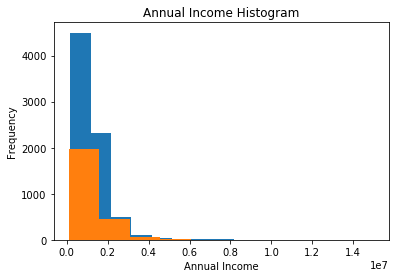

In [55]:
df_train['Annual Income'].plot.hist(title='Annual Income Histogram')
df_test['Annual Income'].plot.hist(title='Annual Income Histogram')
plt.xlabel('Annual Income')

Text(0.5, 0, 'Tax Liens')

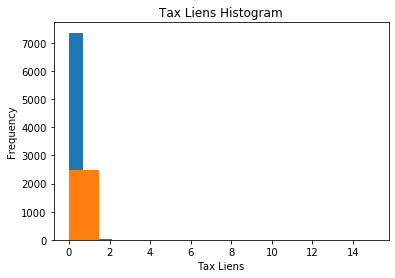

In [56]:
df_train['Tax Liens'].plot.hist(title='Tax Liens Histogram')
df_test['Tax Liens'].plot.hist(title='Tax Liens Histogram')
plt.xlabel('Tax Liens')

Text(0.5, 0, 'Number of Open Accounts')

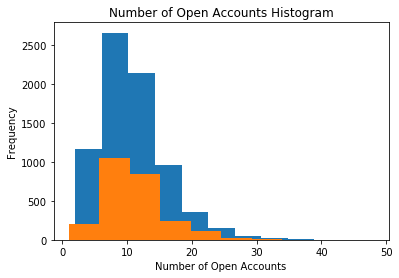

In [57]:
df_train['Number of Open Accounts'].plot.hist(title='Number of Open Accounts Histogram')
df_test['Number of Open Accounts'].plot.hist(title='Number of Open Accounts Histogram')
plt.xlabel('Number of Open Accounts')

Text(0.5, 0, 'Maximum Open Credit')

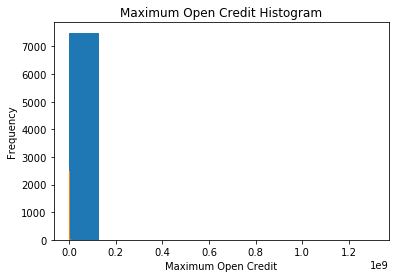

In [59]:
df_train['Maximum Open Credit'].plot.hist(title='Maximum Open Credit Histogram')
df_test['Maximum Open Credit'].plot.hist(title='Maximum Open Credit Histogram')
plt.xlabel('Maximum Open Credit')

Text(0.5, 0, 'Number of Credit Problems')

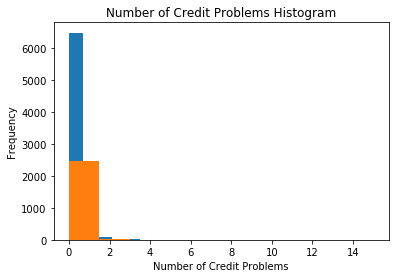

In [60]:
df_train['Number of Credit Problems'].plot.hist(title='Number of Credit Problems Histogram')
df_test['Number of Credit Problems'].plot.hist(title='Number of Credit Problems Histogram')
plt.xlabel('Number of Credit Problems')

Text(0.5, 0, 'Months since last delinquent')

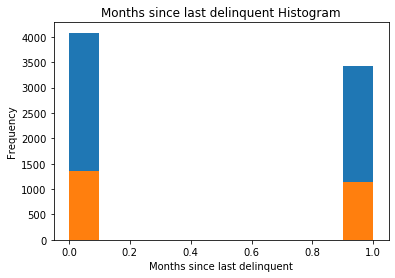

In [61]:
df_train['Months since last delinquent'].plot.hist(title='Months since last delinquent Histogram')
df_test['Months since last delinquent'].plot.hist(title='Months since last delinquent Histogram')
plt.xlabel('Months since last delinquent')

Text(0.5, 0, 'Bankruptcies')

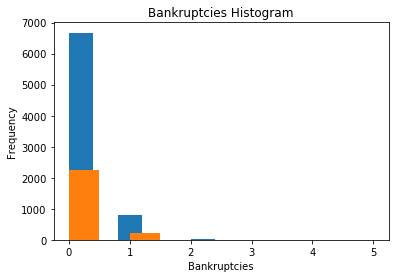

In [62]:
df_train['Bankruptcies'].plot.hist(title='Bankruptcies Histogram')
df_test['Bankruptcies'].plot.hist(title='Bankruptcies Histogram')
plt.xlabel('Bankruptcies')

Text(0.5, 0, 'Current Loan Amount')

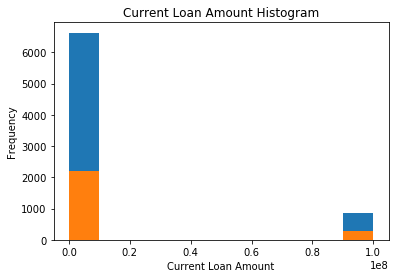

In [63]:
df_train['Current Loan Amount'].plot.hist(title='Current Loan Amount Histogram')
df_test['Current Loan Amount'].plot.hist(title='Current Loan Amount Histogram')
plt.xlabel('Current Loan Amount')

Text(0.5, 0, 'Current Credit Balance')

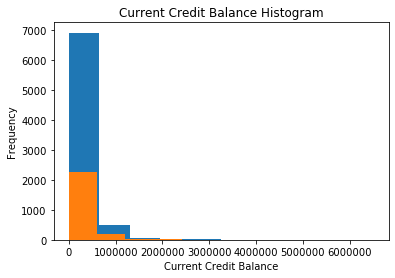

In [64]:
df_train['Current Credit Balance'].plot.hist(title='Current Credit Balance Histogram')
df_test['Current Credit Balance'].plot.hist(title='Current Credit Balance Histogram')
plt.xlabel('Current Credit Balance')

Text(0.5, 0, 'Monthly Debt Balance')

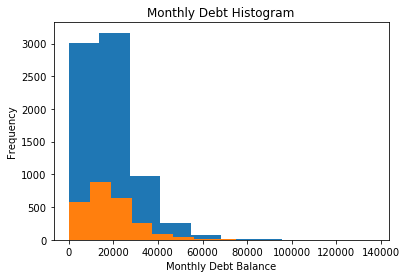

In [65]:
df_train['Monthly Debt'].plot.hist(title='Monthly Debt Histogram')
df_test['Monthly Debt'].plot.hist(title='Monthly Debt Histogram')
plt.xlabel('Monthly Debt Balance')

Text(0.5, 0, 'Credit Score Balance')

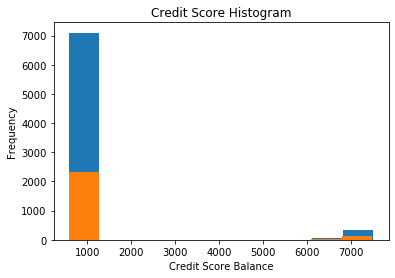

In [66]:
df_train['Credit Score'].plot.hist(title='Credit Score Histogram')
df_test['Credit Score'].plot.hist(title='Credit Score Histogram')
plt.xlabel('Credit Score Balance')

In [67]:
df_train['Credit Score'].value_counts(dropna = False)

730.0     1655
740.0      169
747.0      168
748.0      157
745.0      152
          ... 
616.0        1
585.0        1
620.0        1
6680.0       1
7010.0       1
Name: Credit Score, Length: 268, dtype: int64

In [68]:
df_test['Credit Score'].value_counts(dropna = False)

730.0     536
746.0      56
739.0      55
741.0      54
740.0      50
         ... 
613.0       1
616.0       1
6880.0      1
6890.0      1
6670.0      1
Name: Credit Score, Length: 211, dtype: int64

**Удаляем вспомогательный столбец**

In [72]:
df_train

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,0 years,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,0.0,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,1.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,0.0,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,1162572.0,0 years,0.0,21.0,26.5,1141250.0,0.0,0.0,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,730.0,0


**Проверка на пропуски**

In [73]:
len(df_train) - df_train.count()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

In [74]:
len(df_test) - df_test.count()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
dtype: int64

In [75]:
df_train.loc[df_train['Years in current job']=='< 1 year', 'Years in current job'] = 'less 1 year'
df_test.loc[df_test['Years in current job']=='< 1 year', 'Years in current job'] = 'less 1 year'

### Кодирование признаков<a class="anchor" id="encod"></a>

**Будем кодировать кат. признаки, где уникальных больше двух - one-hot_encoding, где два - label_encoding** 

In [77]:
categorical_features = df_train.select_dtypes(include=['object']).copy()
print(categorical_features.columns)

Index(['Home Ownership', 'Years in current job', 'Purpose', 'Term'], dtype='object')


In [78]:
numerical_features = df_train.select_dtypes(exclude=['object']).copy()
print(numerical_features.columns)

Index(['Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Months since last delinquent',
       'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score', 'Credit Default'],
      dtype='object')


In [79]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in df_train:
    if df_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(df_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(df_train[col])
            # Transform both training and testing data
            df_train[col] = le.transform(df_train[col])
            df_test[col] = le.transform(df_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

1 columns were label encoded.


In [80]:
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

In [81]:
df_train

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,Current Loan Amount,...,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,482087.0,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,1,99999999.0,...,0,0,0,0,0,0,0,0,0,0
1,1025487.0,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,0,264968.0,...,0,0,0,0,0,0,0,0,0,0
2,751412.0,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,1,99999999.0,...,0,0,0,0,0,0,0,0,0,0
3,805068.0,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,1,121396.0,...,0,0,0,0,0,0,0,0,0,0
4,776264.0,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,1,125840.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,402192.0,0.0,3.0,8.5,107866.0,0.0,0.0,0.0,1,129360.0,...,0,0,0,0,1,0,0,0,0,0
7496,1533984.0,0.0,10.0,26.5,686312.0,0.0,1.0,0.0,0,444048.0,...,0,0,0,0,0,0,0,0,0,0
7497,1878910.0,0.0,12.0,32.1,1778920.0,0.0,0.0,0.0,1,99999999.0,...,0,0,0,0,0,0,0,0,0,0
7498,1162572.0,0.0,21.0,26.5,1141250.0,0.0,0.0,0.0,1,615274.0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
df_test

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,Current Loan Amount,...,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,1162572.0,0.0,9.0,12.5,220968.0,0.0,1.0,0.0,1,162470.0,...,0,0,0,0,0,0,0,0,0,0
1,231838.0,0.0,6.0,32.7,55946.0,0.0,1.0,0.0,1,78298.0,...,1,0,0,0,0,0,0,0,0,0
2,1152540.0,0.0,10.0,13.7,204600.0,0.0,0.0,0.0,1,200178.0,...,0,0,0,0,0,0,0,0,0,0
3,1220313.0,0.0,16.0,17.0,456302.0,0.0,1.0,0.0,1,217382.0,...,0,0,0,0,0,0,0,0,0,0
4,2340952.0,0.0,11.0,23.6,1207272.0,0.0,0.0,0.0,0,777634.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1020053.0,0.0,14.0,29.1,559152.0,1.0,1.0,1.0,1,99999999.0,...,0,0,0,0,0,0,0,0,0,0
2496,1162572.0,0.0,15.0,17.0,1737780.0,0.0,1.0,0.0,1,468512.0,...,0,0,0,0,0,0,0,0,0,0
2497,1171806.0,0.0,48.0,12.8,1706430.0,0.0,0.0,0.0,1,430496.0,...,0,0,0,0,0,0,0,0,0,0
2498,723520.0,0.0,14.0,28.8,945780.0,0.0,0.0,0.0,1,257774.0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
print('Training Features shape: ', df_train.shape)
print('Testing Features shape: ', df_test.shape)

Training Features shape:  (7500, 45)
Testing Features shape:  (2500, 43)


**Согласование данных в train и test**

In [84]:
df_train.columns

Index(['Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Months since last delinquent',
       'Bankruptcies', 'Term', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score', 'Credit Default',
       'Home Ownership_Have Mortgage', 'Home Ownership_Home Mortgage',
       'Home Ownership_Own Home', 'Home Ownership_Rent',
       'Years in current job_0 years', 'Years in current job_1 year',
       'Years in current job_10+ years', 'Years in current job_2 years',
       'Years in current job_3 years', 'Years in current job_4 years',
       'Years in current job_5 years', 'Years in current job_6 years',
       'Years in current job_7 years', 'Years in current job_8 years',
       'Years in current job_9 years', 'Years in current job_less 1 year',
       'Purpose_business loan', 'Purpose_buy a car', 'Purpose_buy house',
       'Purpose_debt consolidation', 'Pur

In [85]:
df_test.columns

Index(['Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Months since last delinquent',
       'Bankruptcies', 'Term', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score', 'Home Ownership_Have Mortgage',
       'Home Ownership_Home Mortgage', 'Home Ownership_Own Home',
       'Home Ownership_Rent', 'Years in current job_0 years',
       'Years in current job_1 year', 'Years in current job_10+ years',
       'Years in current job_2 years', 'Years in current job_3 years',
       'Years in current job_4 years', 'Years in current job_5 years',
       'Years in current job_6 years', 'Years in current job_7 years',
       'Years in current job_8 years', 'Years in current job_9 years',
       'Years in current job_less 1 year', 'Purpose_business loan',
       'Purpose_buy a car', 'Purpose_buy house', 'Purpose_debt consolidation',
       'Purpose_educational e

In [86]:
train_labels = df_train['Credit Default']
df_train, df_test = df_train.align(df_test, join = 'inner', axis=1)
df_train['Credit Default'] = train_labels

print('Training Features shape: ', df_train.shape)
print('Testing Features shape: ', df_test.shape)

Training Features shape:  (7500, 44)
Testing Features shape:  (2500, 43)


### Проверка на корреляции<a class="anchor" id="corr"></a>

In [87]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

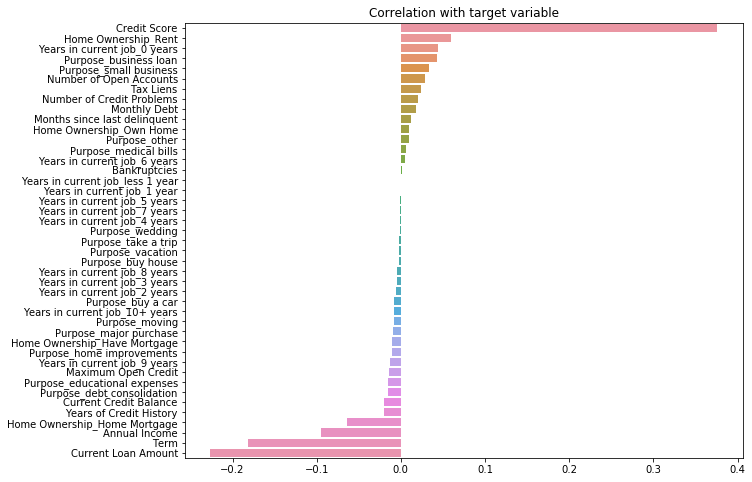

In [88]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

### Обзор признака Credit_Score<a class="anchor" id="score"></a>

**Так как самые значимые признак это Credit Score, рассмотрим его поподробнее**

In [89]:
df_train['Credit Score'].describe()

count    7500.000000
mean     1063.669733
std      1438.383940
min       585.000000
25%       718.000000
50%       730.000000
75%       740.000000
max      7510.000000
Name: Credit Score, dtype: float64

**Так как Credit Score содержит значения до 1000 и более 6000, а между ними ничего, рассмотрим неколько интералов**

(600, 770)

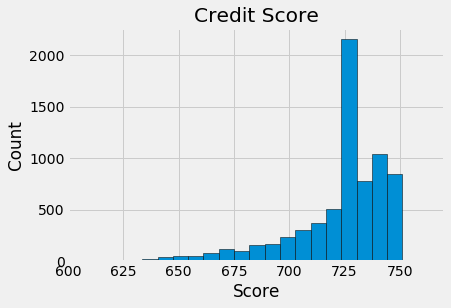

In [90]:
plt.style.use('fivethirtyeight')
plt.hist(df_train['Credit Score'], edgecolor = 'k', bins = 1000)
plt.title('Credit Score'); plt.xlabel('Score'); plt.ylabel('Count');
plt.xlim([600, 770])

(0, 80)

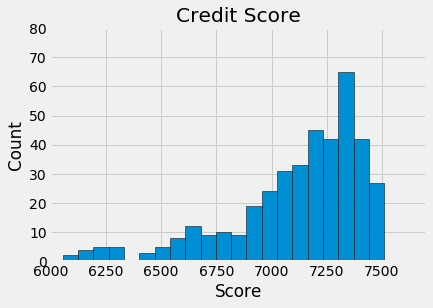

In [91]:
plt.style.use('fivethirtyeight')
plt.hist(df_train['Credit Score'], edgecolor = 'k', bins = 100)
plt.title('Credit Score'); plt.xlabel('Score'); plt.ylabel('Count');
plt.xlim([6000, 7700])
plt.ylim([0, 80])

(500, 800)

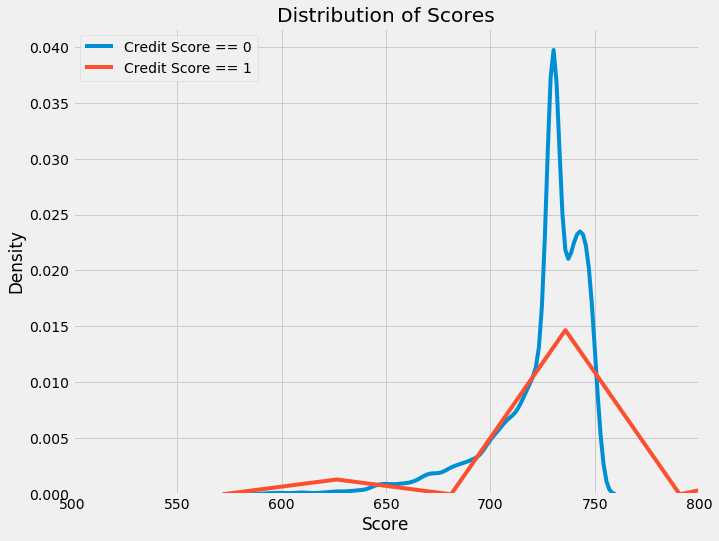

In [92]:
plt.figure(figsize = (10, 8))
sns.kdeplot(df_train.loc[df_train['Credit Default'] == 0, 'Credit Score'], label = 'Credit Score == 0')
sns.kdeplot(df_train.loc[df_train['Credit Default'] == 1, 'Credit Score'], label = 'Credit Score == 1')
plt.xlabel('Score'); plt.ylabel('Density'); plt.title('Distribution of Scores')
plt.xlim([500, 800])

(0.0, 0.001)

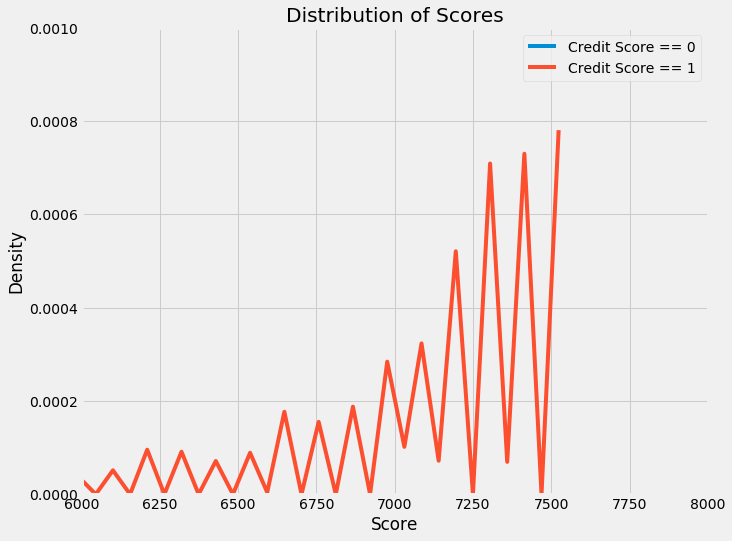

In [93]:
plt.figure(figsize = (10, 8))
sns.kdeplot(df_train.loc[df_train['Credit Default'] == 0, 'Credit Score'], label = 'Credit Score == 0')
sns.kdeplot(df_train.loc[df_train['Credit Default'] == 1, 'Credit Score'], label = 'Credit Score == 1')
plt.xlabel('Score'); plt.ylabel('Density'); plt.title('Distribution of Scores')
plt.xlim([6000, 8000])
plt.ylim([0.000, 0.001])

In [94]:
score_data = df_train[['Credit Default', 'Credit Score']]
score_data['Score_BINNED'] = pd.cut(score_data['Credit Score'], bins = np.linspace(585, 755, num = 10))
score_data.head(10)

<ipython-input-94-d7a9bacd1950>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_data['Score_BINNED'] = pd.cut(score_data['Credit Score'], bins = np.linspace(585, 755, num = 10))


,Credit Default,Credit Score,Score_BINNED
0,0,749.0,"(736.111, 755.0]"
1,1,737.0,"(736.111, 755.0]"
2,0,742.0,"(736.111, 755.0]"
3,0,694.0,"(679.444, 698.333]"
4,0,719.0,"(717.222, 736.111]"
5,1,730.0,"(717.222, 736.111]"
6,0,745.0,"(736.111, 755.0]"
7,1,705.0,"(698.333, 717.222]"
8,0,730.0,"(717.222, 736.111]"
9,1,730.0,"(717.222, 736.111]"


In [95]:
score_groups  = score_data.groupby('Score_BINNED').mean()
score_groups
# можно сюда добавить и score , которые выражены в тысячах,но они все невозвратные поэтому не буду

,Credit Default,Credit Score
Score_BINNED,,
"(585.0, 603.889]",0.470588,595.000000
"(603.889, 622.778]",0.588235,614.235294
"(622.778, 641.667]",0.442308,632.865385
"(641.667, 660.556]",0.367347,651.680272
"(660.556, 679.444]",0.378378,670.949807
"(679.444, 698.333]",0.321739,689.778261
"(698.333, 717.222]",0.220944,708.993096
"(717.222, 736.111]",0.278138,728.876966
"(736.111, 755.0]",0.132309,743.437066


Text(0.5, 1.0, 'Failure to Repay by Score Group')

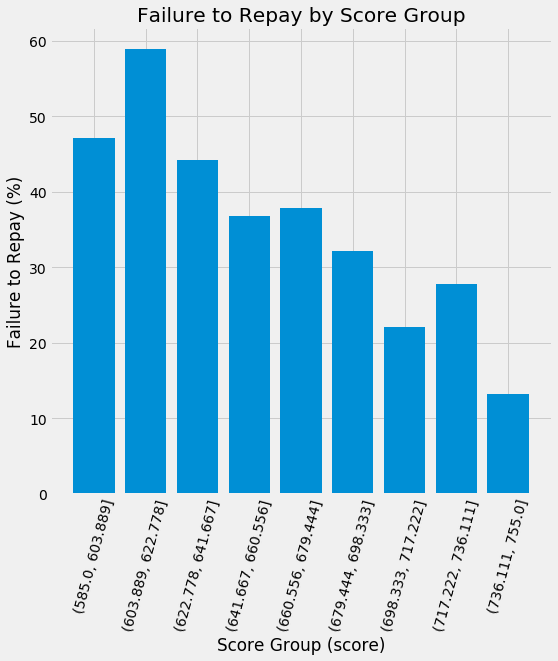

In [96]:
plt.figure(figsize = (8, 8))

plt.bar(score_groups.index.astype(str), 100 * score_groups['Credit Default'])

plt.xticks(rotation = 75); plt.xlabel('Score Group (score)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Score Group')

### Подготовка данных к моделированию, скалирование <a class="anchor" id="scal"></a>

In [99]:
scaler = StandardScaler()
df_norm = df_train.copy()

In [100]:
NUM_Features = ['Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Months since last delinquent',
       'Bankruptcies', 'Term', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score']

In [101]:
df_norm[NUM_Features] = scaler.fit_transform(df_norm[NUM_Features])

In [103]:
df_work_train = df_norm.copy()
df_work_train

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,Current Loan Amount,...,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Credit Default
0,-1.112335,-0.110953,-0.026674,1.133645,-0.016174,1.664779,-0.915306,2.545732,0.591517,2.760520,...,0,0,0,0,0,0,0,0,0,0
1,-0.394462,-0.110953,0.788223,-0.428528,0.014763,-0.340979,-0.915306,-0.337099,-1.690569,-0.363620,...,0,0,0,0,0,0,0,0,0,1
2,-0.756536,-0.110953,-0.026674,2.369181,0.014807,-0.340979,-0.915306,-0.337099,0.591517,2.760520,...,0,0,0,0,0,0,0,0,0,0
3,-0.685653,-0.110953,-0.637847,0.593985,-0.049781,1.664779,-0.915306,2.545732,0.591517,-0.368118,...,0,0,0,0,0,0,0,0,0,0
4,-0.723705,-0.110953,0.380774,-0.669954,-0.034902,1.664779,-0.915306,-0.337099,0.591517,-0.367978,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,-1.217883,-0.110953,-1.656468,-1.394234,-0.052248,-0.340979,-0.915306,-0.337099,0.591517,-0.367868,...,0,0,0,0,1,0,0,0,0,0
7496,0.277301,-0.110953,-0.230398,1.162048,-0.016152,-0.340979,1.092531,-0.337099,-1.690569,-0.358011,...,0,0,0,0,0,0,0,0,0,1
7497,0.732974,-0.110953,0.177050,1.957336,0.052029,-0.340979,-0.915306,-0.337099,0.591517,2.760520,...,0,0,0,0,0,0,0,0,0,0
7498,-0.213363,-0.110953,2.010568,1.162048,0.012237,-0.340979,-0.915306,-0.337099,0.591517,-0.352647,...,0,0,0,0,0,0,0,0,0,0


In [242]:
df_norm_test = df_test.copy()
df_norm_test

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,Current Loan Amount,...,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,1162572.0,0.0,9.0,12.5,220968.0,0.0,1.0,0.0,1,162470.0,...,0,0,0,0,0,0,0,0,0,0
1,231838.0,0.0,6.0,32.7,55946.0,0.0,1.0,0.0,1,78298.0,...,1,0,0,0,0,0,0,0,0,0
2,1152540.0,0.0,10.0,13.7,204600.0,0.0,0.0,0.0,1,200178.0,...,0,0,0,0,0,0,0,0,0,0
3,1220313.0,0.0,16.0,17.0,456302.0,0.0,1.0,0.0,1,217382.0,...,0,0,0,0,0,0,0,0,0,0
4,2340952.0,0.0,11.0,23.6,1207272.0,0.0,0.0,0.0,0,777634.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1020053.0,0.0,14.0,29.1,559152.0,1.0,1.0,1.0,1,99999999.0,...,0,0,0,0,0,0,0,0,0,0
2496,1162572.0,0.0,15.0,17.0,1737780.0,0.0,1.0,0.0,1,468512.0,...,0,0,0,0,0,0,0,0,0,0
2497,1171806.0,0.0,48.0,12.8,1706430.0,0.0,0.0,0.0,1,430496.0,...,0,0,0,0,0,0,0,0,0,0
2498,723520.0,0.0,14.0,28.8,945780.0,0.0,0.0,0.0,1,257774.0,...,0,0,0,0,0,0,0,0,0,0


In [243]:
df_norm_test[NUM_Features] = scaler.fit_transform(df_norm_test[NUM_Features])
df_test = df_norm_test.copy()
df_test

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,Current Loan Amount,...,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,-0.197689,-0.091141,-0.450224,-0.803220,-0.323879,-0.289398,1.090478,-0.299225,0.585973,-0.371832,...,0,0,0,0,0,0,0,0,0,0
1,-1.330546,-0.091141,-1.068551,1.981755,-0.433044,-0.289398,1.090478,-0.299225,0.585973,-0.374441,...,1,0,0,0,0,0,0,0,0,0
2,-0.209899,-0.091141,-0.244115,-0.637776,-0.334707,-0.289398,-0.917029,-0.299225,0.585973,-0.370663,...,0,0,0,0,0,0,0,0,0,0
3,-0.127408,-0.091141,0.992538,-0.182805,-0.168202,-0.289398,1.090478,-0.299225,0.585973,-0.370129,...,0,0,0,0,0,0,0,0,0,0
4,1.236595,-0.091141,-0.038006,0.727138,0.328576,-0.289398,-0.917029,-0.299225,-1.706565,-0.352759,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,-0.371158,-0.091141,0.580320,1.485423,-0.100166,1.497011,1.090478,2.502503,0.585973,2.723472,...,0,0,0,0,0,0,0,0,0,0
2496,-0.197689,-0.091141,0.786429,-0.182805,0.679515,-0.289398,1.090478,-0.299225,0.585973,-0.362343,...,0,0,0,0,0,0,0,0,0,0
2497,-0.186449,-0.091141,7.588024,-0.761859,0.658776,-0.289398,-0.917029,-0.299225,0.585973,-0.363522,...,0,0,0,0,0,0,0,0,0,0
2498,-0.732088,-0.091141,0.580320,1.444062,0.155595,-0.289398,-0.917029,-0.299225,0.585973,-0.368877,...,0,0,0,0,0,0,0,0,0,0


**Разбиение на train и test**

In [244]:
df_train.columns

Index(['Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Months since last delinquent',
       'Bankruptcies', 'Term', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score', 'Home Ownership_Have Mortgage',
       'Home Ownership_Home Mortgage', 'Home Ownership_Own Home',
       'Home Ownership_Rent', 'Years in current job_0 years',
       'Years in current job_1 year', 'Years in current job_10+ years',
       'Years in current job_2 years', 'Years in current job_3 years',
       'Years in current job_4 years', 'Years in current job_5 years',
       'Years in current job_6 years', 'Years in current job_7 years',
       'Years in current job_8 years', 'Years in current job_9 years',
       'Years in current job_less 1 year', 'Purpose_business loan',
       'Purpose_buy a car', 'Purpose_buy house', 'Purpose_debt consolidation',
       'Purpose_educational e

In [245]:
TARGET_NAME = 'Credit Default'

In [246]:
FEATURES = df_work_train.columns.drop(['Credit Default', 'Months since last delinquent']).tolist()

In [247]:
X = df_work_train[FEATURES]
X

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Term,Current Loan Amount,Current Credit Balance,...,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,-1.112335,-0.110953,-0.026674,1.133645,-0.016174,1.664779,2.545732,0.591517,2.760520,-0.762772,...,0,0,0,0,0,0,0,0,0,0
1,-0.394462,-0.110953,0.788223,-0.428528,0.014763,-0.340979,-0.337099,-1.690569,-0.363620,0.330781,...,0,0,0,0,0,0,0,0,0,0
2,-0.756536,-0.110953,-0.026674,2.369181,0.014807,-0.340979,-0.337099,0.591517,2.760520,0.058379,...,0,0,0,0,0,0,0,0,0,0
3,-0.685653,-0.110953,-0.637847,0.593985,-0.049781,1.664779,2.545732,0.591517,-0.368118,-0.610282,...,0,0,0,0,0,0,0,0,0,0
4,-0.723705,-0.110953,0.380774,-0.669954,-0.034902,1.664779,-0.337099,0.591517,-0.367978,-0.618292,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,-1.217883,-0.110953,-1.656468,-1.394234,-0.052248,-0.340979,-0.337099,0.591517,-0.367868,-0.680639,...,0,0,0,0,0,1,0,0,0,0
7496,0.277301,-0.110953,-0.230398,1.162048,-0.016152,-0.340979,-0.337099,-1.690569,-0.358011,0.524039,...,0,0,0,0,0,0,0,0,0,0
7497,0.732974,-0.110953,0.177050,1.957336,0.052029,-0.340979,-0.337099,0.591517,2.760520,0.591407,...,0,0,0,0,0,0,0,0,0,0
7498,-0.213363,-0.110953,2.010568,1.162048,0.012237,-0.340979,-0.337099,0.591517,-0.352647,0.585907,...,0,0,0,0,0,0,0,0,0,0


In [248]:
y = df_work_train[TARGET_NAME]
y

0       0
1       1
2       0
3       0
4       0
       ..
7495    0
7496    1
7497    0
7498    0
7499    0
Name: Credit Default, Length: 7500, dtype: int64

In [249]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.33)

**Балансировка целевой переменной**

In [250]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3580
1    2890
Name: Credit Default, dtype: int64

In [251]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Построение и оценка базовых моделей <a class="anchor" id="model"></a>

In [252]:
final_model_cat = catb.CatBoostClassifier(n_estimators=500, max_depth=3, l2_leaf_reg=1,
                                      silent=True, random_state=21)
final_model_cat.fit(X_train, y_train)
                        
y_train_pred = final_model_cat.predict(X_train)
y_test_pred = final_model_cat.predict(X_test)
y_test_pred_probs = final_model_cat.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.86      0.79      3580
           1       0.78      0.60      0.68      2890

    accuracy                           0.75      6470
   macro avg       0.75      0.73      0.73      6470
weighted avg       0.75      0.75      0.74      6470

TEST

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      1807
           1       0.55      0.52      0.53       668

    accuracy                           0.76      2475
   macro avg       0.69      0.68      0.68      2475
weighted avg       0.75      0.76      0.75      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1525  282
1                323  345


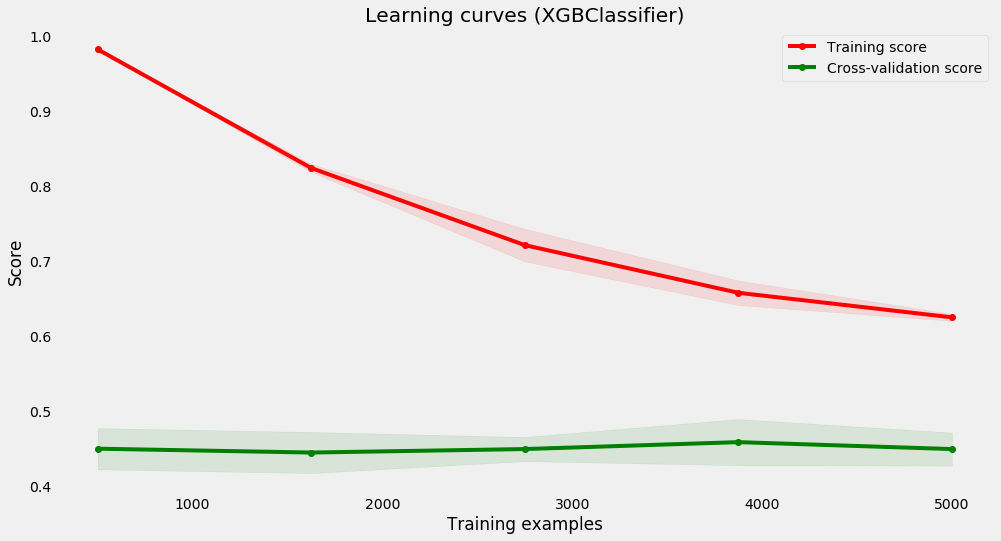

In [253]:
show_learning_curve_plot(model_xgb, X, y)

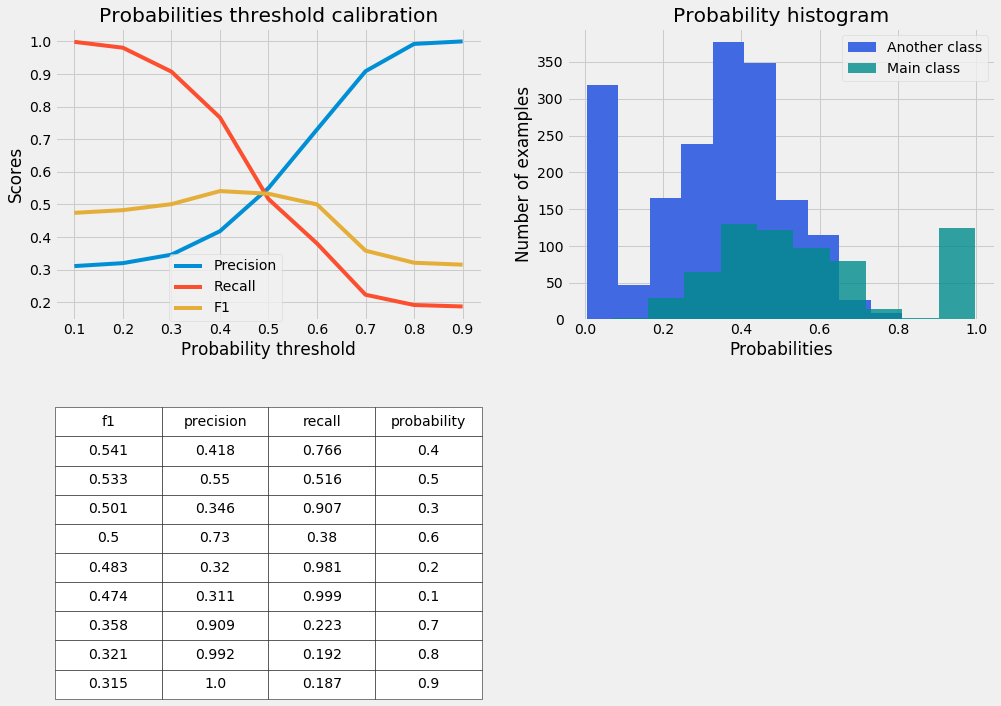

In [254]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

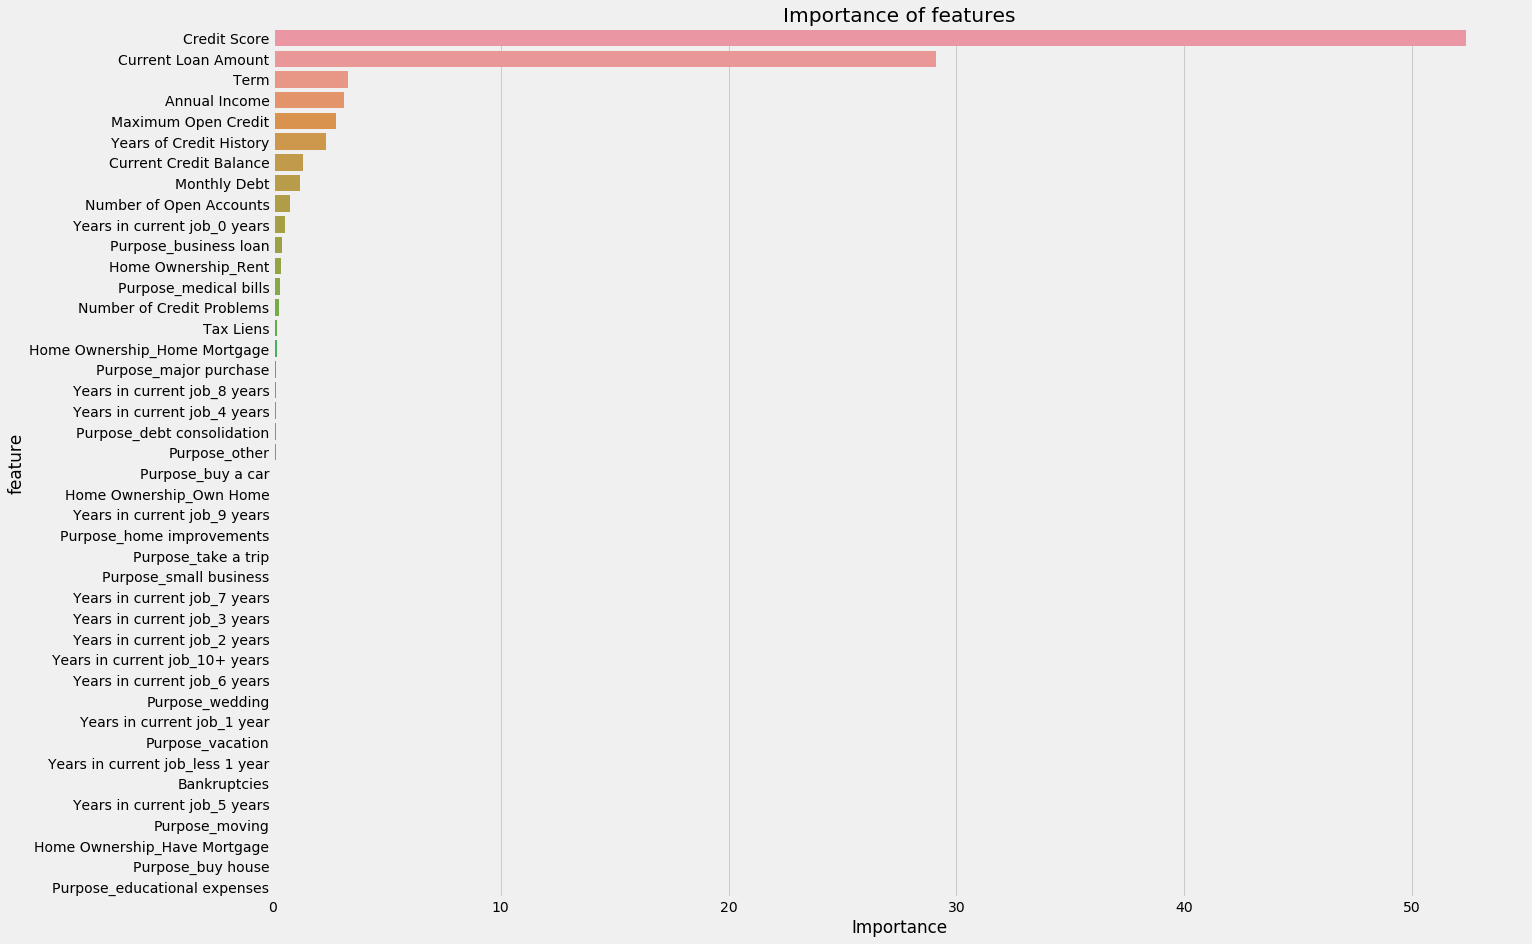

In [255]:
important_features_top = show_feature_importances(X_train.columns, final_model_cat.feature_importances_, get_top=20)

In [286]:
final_model_cat = catb.CatBoostClassifier(n_estimators=500, max_depth=2, l2_leaf_reg=10,
                                      silent=True, random_state=21)
final_model_cat.fit(X_train, y_train)
                        
y_train_pred = final_model_cat.predict(X_train)
y_test_pred = final_model_cat.predict(X_test)
y_test_pred_probs = final_model_cat.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.70      0.85      0.77      3580
           1       0.75      0.55      0.63      2890

    accuracy                           0.72      6470
   macro avg       0.72      0.70      0.70      6470
weighted avg       0.72      0.72      0.71      6470

TEST

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      1807
           1       0.55      0.52      0.53       668

    accuracy                           0.75      2475
   macro avg       0.69      0.68      0.68      2475
weighted avg       0.75      0.75      0.75      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1518  289
1                319  349


In [257]:
important_features_top

['Credit Score',
 'Current Loan Amount',
 'Term',
 'Annual Income',
 'Maximum Open Credit',
 'Years of Credit History',
 'Current Credit Balance',
 'Monthly Debt',
 'Number of Open Accounts',
 'Years in current job_0 years',
 'Purpose_business loan',
 'Home Ownership_Rent',
 'Purpose_medical bills',
 'Number of Credit Problems',
 'Tax Liens',
 'Home Ownership_Home Mortgage',
 'Purpose_major purchase',
 'Years in current job_8 years',
 'Years in current job_4 years',
 'Purpose_debt consolidation']

### Финальная модель<a class="anchor" id="final_model"></a>

In [288]:
final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3, l2_leaf_reg=5,
                                      silent=True, random_state=21)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.86      0.79      3580
           1       0.77      0.60      0.67      2890

    accuracy                           0.74      6470
   macro avg       0.75      0.73      0.73      6470
weighted avg       0.75      0.74      0.74      6470

TEST

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      1807
           1       0.54      0.52      0.53       668

    accuracy                           0.75      2475
   macro avg       0.69      0.68      0.68      2475
weighted avg       0.75      0.75      0.75      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1516  291
1                320  348


In [289]:
N = 50
porog = 0.4975
y_p = (y_test_pred_probs[:, 1]>porog).astype(int)

get_classification_report(y_train, y_train_pred, y_test, y_p)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.86      0.79      3580
           1       0.77      0.60      0.67      2890

    accuracy                           0.74      6470
   macro avg       0.75      0.73      0.73      6470
weighted avg       0.75      0.74      0.74      6470

TEST

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1807
           1       0.54      0.53      0.53       668

    accuracy                           0.75      2475
   macro avg       0.68      0.68      0.68      2475
weighted avg       0.75      0.75      0.75      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1503  304
1                316  352


In [290]:
df_test[important_features_top]

,Credit Score,Current Loan Amount,Term,Annual Income,Maximum Open Credit,Years of Credit History,Current Credit Balance,Monthly Debt,Number of Open Accounts,Years in current job_0 years,Purpose_business loan,Home Ownership_Rent,Purpose_medical bills,Number of Credit Problems,Tax Liens,Home Ownership_Home Mortgage,Purpose_major purchase,Years in current job_8 years,Years in current job_4 years,Purpose_debt consolidation
0,-0.256327,-0.371832,0.585973,-0.197689,-0.323879,-0.803220,-0.503642,-0.992788,-0.450224,0,0,1,0,-0.289398,-0.091141,0,0,0,1,1
1,-0.276144,-0.374441,0.585973,-1.330546,-0.433044,1.981755,-0.661931,-1.382250,-1.068551,0,0,1,0,-0.289398,-0.091141,0,0,0,0,0
2,3.917884,-0.370663,0.585973,-0.209899,-0.334707,-0.637776,-0.396341,0.039653,-0.244115,0,0,0,0,-0.289398,-0.091141,1,0,0,0,1
3,-0.250574,-0.370129,0.585973,-0.127408,-0.168202,-0.182805,-0.219968,0.804714,0.992538,0,0,0,0,-0.289398,-0.091141,1,0,0,0,1
4,-0.271669,-0.352759,-1.706565,1.236595,0.328576,0.727138,0.341051,2.108349,-0.038006,0,0,0,0,-0.289398,-0.091141,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,-0.246739,2.723472,0.585973,-0.371158,-0.100166,1.485423,-0.353391,-0.279454,0.580320,0,0,0,0,1.497011,-0.091141,1,0,0,0,1
2496,-0.256327,-0.362343,0.585973,-0.197689,0.679515,-0.182805,3.021663,1.275793,0.786429,0,0,0,0,-0.289398,-0.091141,1,0,0,0,1
2497,-0.278701,-0.363522,0.585973,-0.186449,0.658776,-0.761859,1.004799,1.615088,7.588024,0,0,0,0,-0.289398,-0.091141,1,0,0,0,1
2498,-0.247378,-0.368877,0.585973,-0.732088,0.155595,1.444062,0.250779,-0.412885,0.580320,0,0,1,0,-0.289398,-0.091141,0,0,0,0,1


In [291]:
y_df_test_pred = final_model.predict(df_test[important_features_top])
y_df_test_pred

array([0, 0, 1, ..., 0, 0, 1], dtype=int64)

In [292]:
len(y_df_test_pred)

2500

In [293]:
y_df_test_pred.sum()

361

In [294]:
y_df_test_pred_probs = final_model.predict_proba(df_test[important_features_top])

In [295]:
y_df_test_pred_probs

array([[0.66365836, 0.33634164],
       [0.66041948, 0.33958052],
       [0.02941451, 0.97058549],
       ...,
       [0.83068062, 0.16931938],
       [0.78900134, 0.21099866],
       [0.12919089, 0.87080911]])

In [296]:
predictions = (y_df_test_pred_probs[:, 1]>porog).astype(int)

In [297]:
predictions

array([0, 0, 1, ..., 0, 0, 1])

In [298]:
len(predictions)

2500

In [299]:
predictions.sum()

366

In [300]:
test_sub = pd.read_csv('course_project_test.csv')
output = pd.DataFrame({'Credit Default': predictions})
output.to_csv('my_submisson.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [301]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

In [302]:
df_sub = pd.read_csv('my_submisson.csv')
df_sub.head()

,Credit Default
0,0
1,0
2,1
3,0
4,0


In [303]:
366/2500

0.1464